# Clustering analysis and PCA #

### IMPORTANT: Please make sure that you are using the bash kernel to run this notebook.###

In [20]:
### Set up variables storing the location of our data
### The proper way to load your variables is with the ~/.bashrc command, but this is very slow in iPython 
export SUNETID="$(whoami)"
export WORK_DIR="/srv/scratch/training_camp/tc2017/${SUNETID}"
export DATA_DIR="${WORK_DIR}/data"
export FASTQ_DIR="${DATA_DIR}/fastq/"
export SRC_DIR="${WORK_DIR}/src/training_camp/src/"

export ANALYSIS_DIR="${WORK_DIR}/analysis/"
export TRIMMED_DIR="$ANALYSIS_DIR/trimmed"
export ALIGNMENT_DIR="$ANALYSIS_DIR/aligned/"
export TAGALIGN_DIR="$ANALYSIS_DIR/tagAlign/"
export PEAKS_DIR="$ANALYSIS_DIR/peaks/"
export SIGNAL_DIR="${ANALYSIS_DIR}signal/"
export FOLDCHANGE_DIR="${SIGNAL_DIR}foldChange/"
export COUNTS_DIR="${SIGNAL_DIR}counts/"

export YEAST_DIR="/srv/scratch/training_camp/saccer3/seq"
export YEAST_INDEX="/srv/scratch/training_camp/saccer3/bowtie2_index/saccer3"
export YEAST_CHR="/srv/scratch/training_camp/saccer3/sacCer3.chrom.sizes"

export TMP="${WORK_DIR}/tmp"
export TEMP=$TMP 
export TMPDIR=$TMP

export RLIBS=$RLIBS:"/usr/local/lib/R/site-library"

export MASTER_DATA="/srv/scratch/training_camp/data/tc2017"

In this tutorial we will focus on the clustering and PCA analysis steps of the pipeline: 
![Analysis pipeline](images/part3.png)

## Missing R packages##

When running the scripts in this section, if you get an error saying the gplots package has not been installed, you can install the package locally by  running the **3.5 Install R packages** notebook.

## The process_peaks.sh script ##

Cluster analysis is a simple way to visualize patterns in the data. By clustering peaks according to their signal across different time points, we may find groups of peaks that have similar behavior across these time points. By clustering samples according to their signal across peaks, we can perform a simple sanity check of data quality ‐ samples of the same time point should cluster together.

We have developed a script to perform all the following steps. NOTE: You will see data for all 20 samples on the heatmap, not just the one sample that you analyzed. In the preprocess_peaks.sh script, we point the code to analyze the fold change & counts file for all the data that we generated prior to the tutorial -- that way you can examine all the data without having to wait for all your samples to finish aligning! 

extracted signal
combined the data

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 
[1] "Done. Plot is called /srv/scratch/training_camp/tc2017/user1/analysis/signal//counts_cluster.png"

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 
[1] "Done. Plot is called /srv/scratch/training_camp/tc2017/user1/analysis/signal//foldChange_cluster.png"


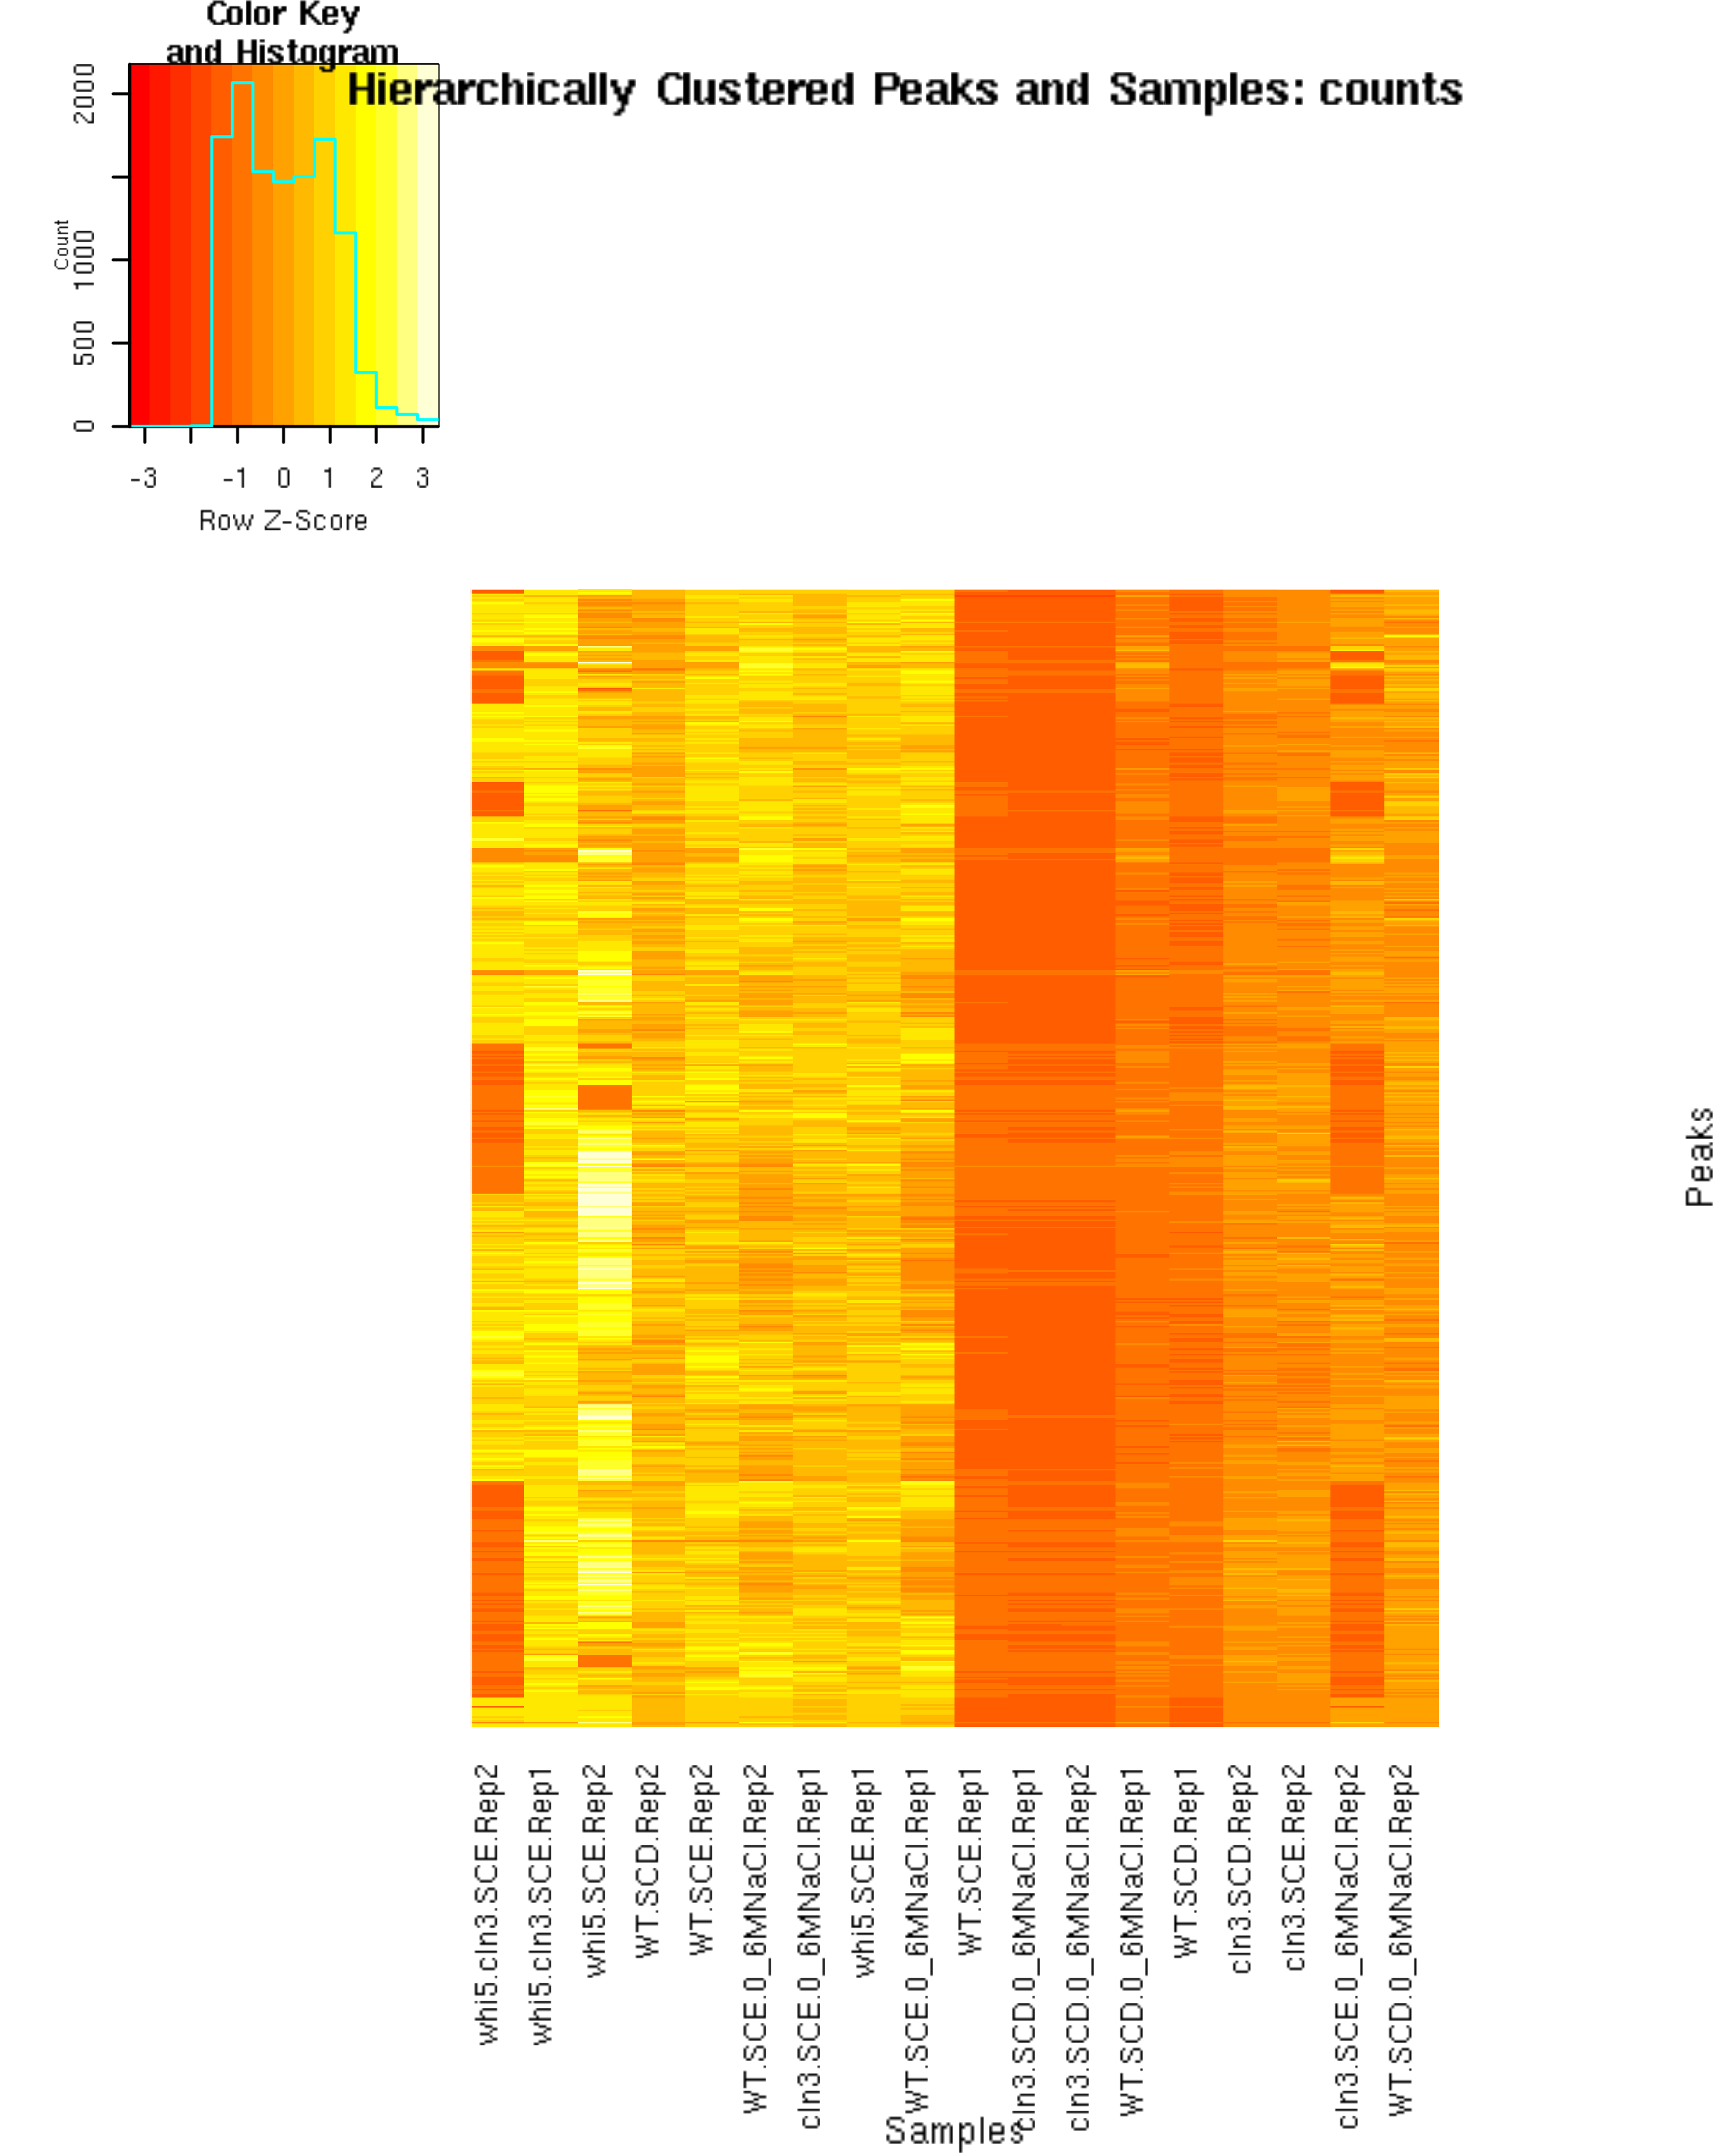

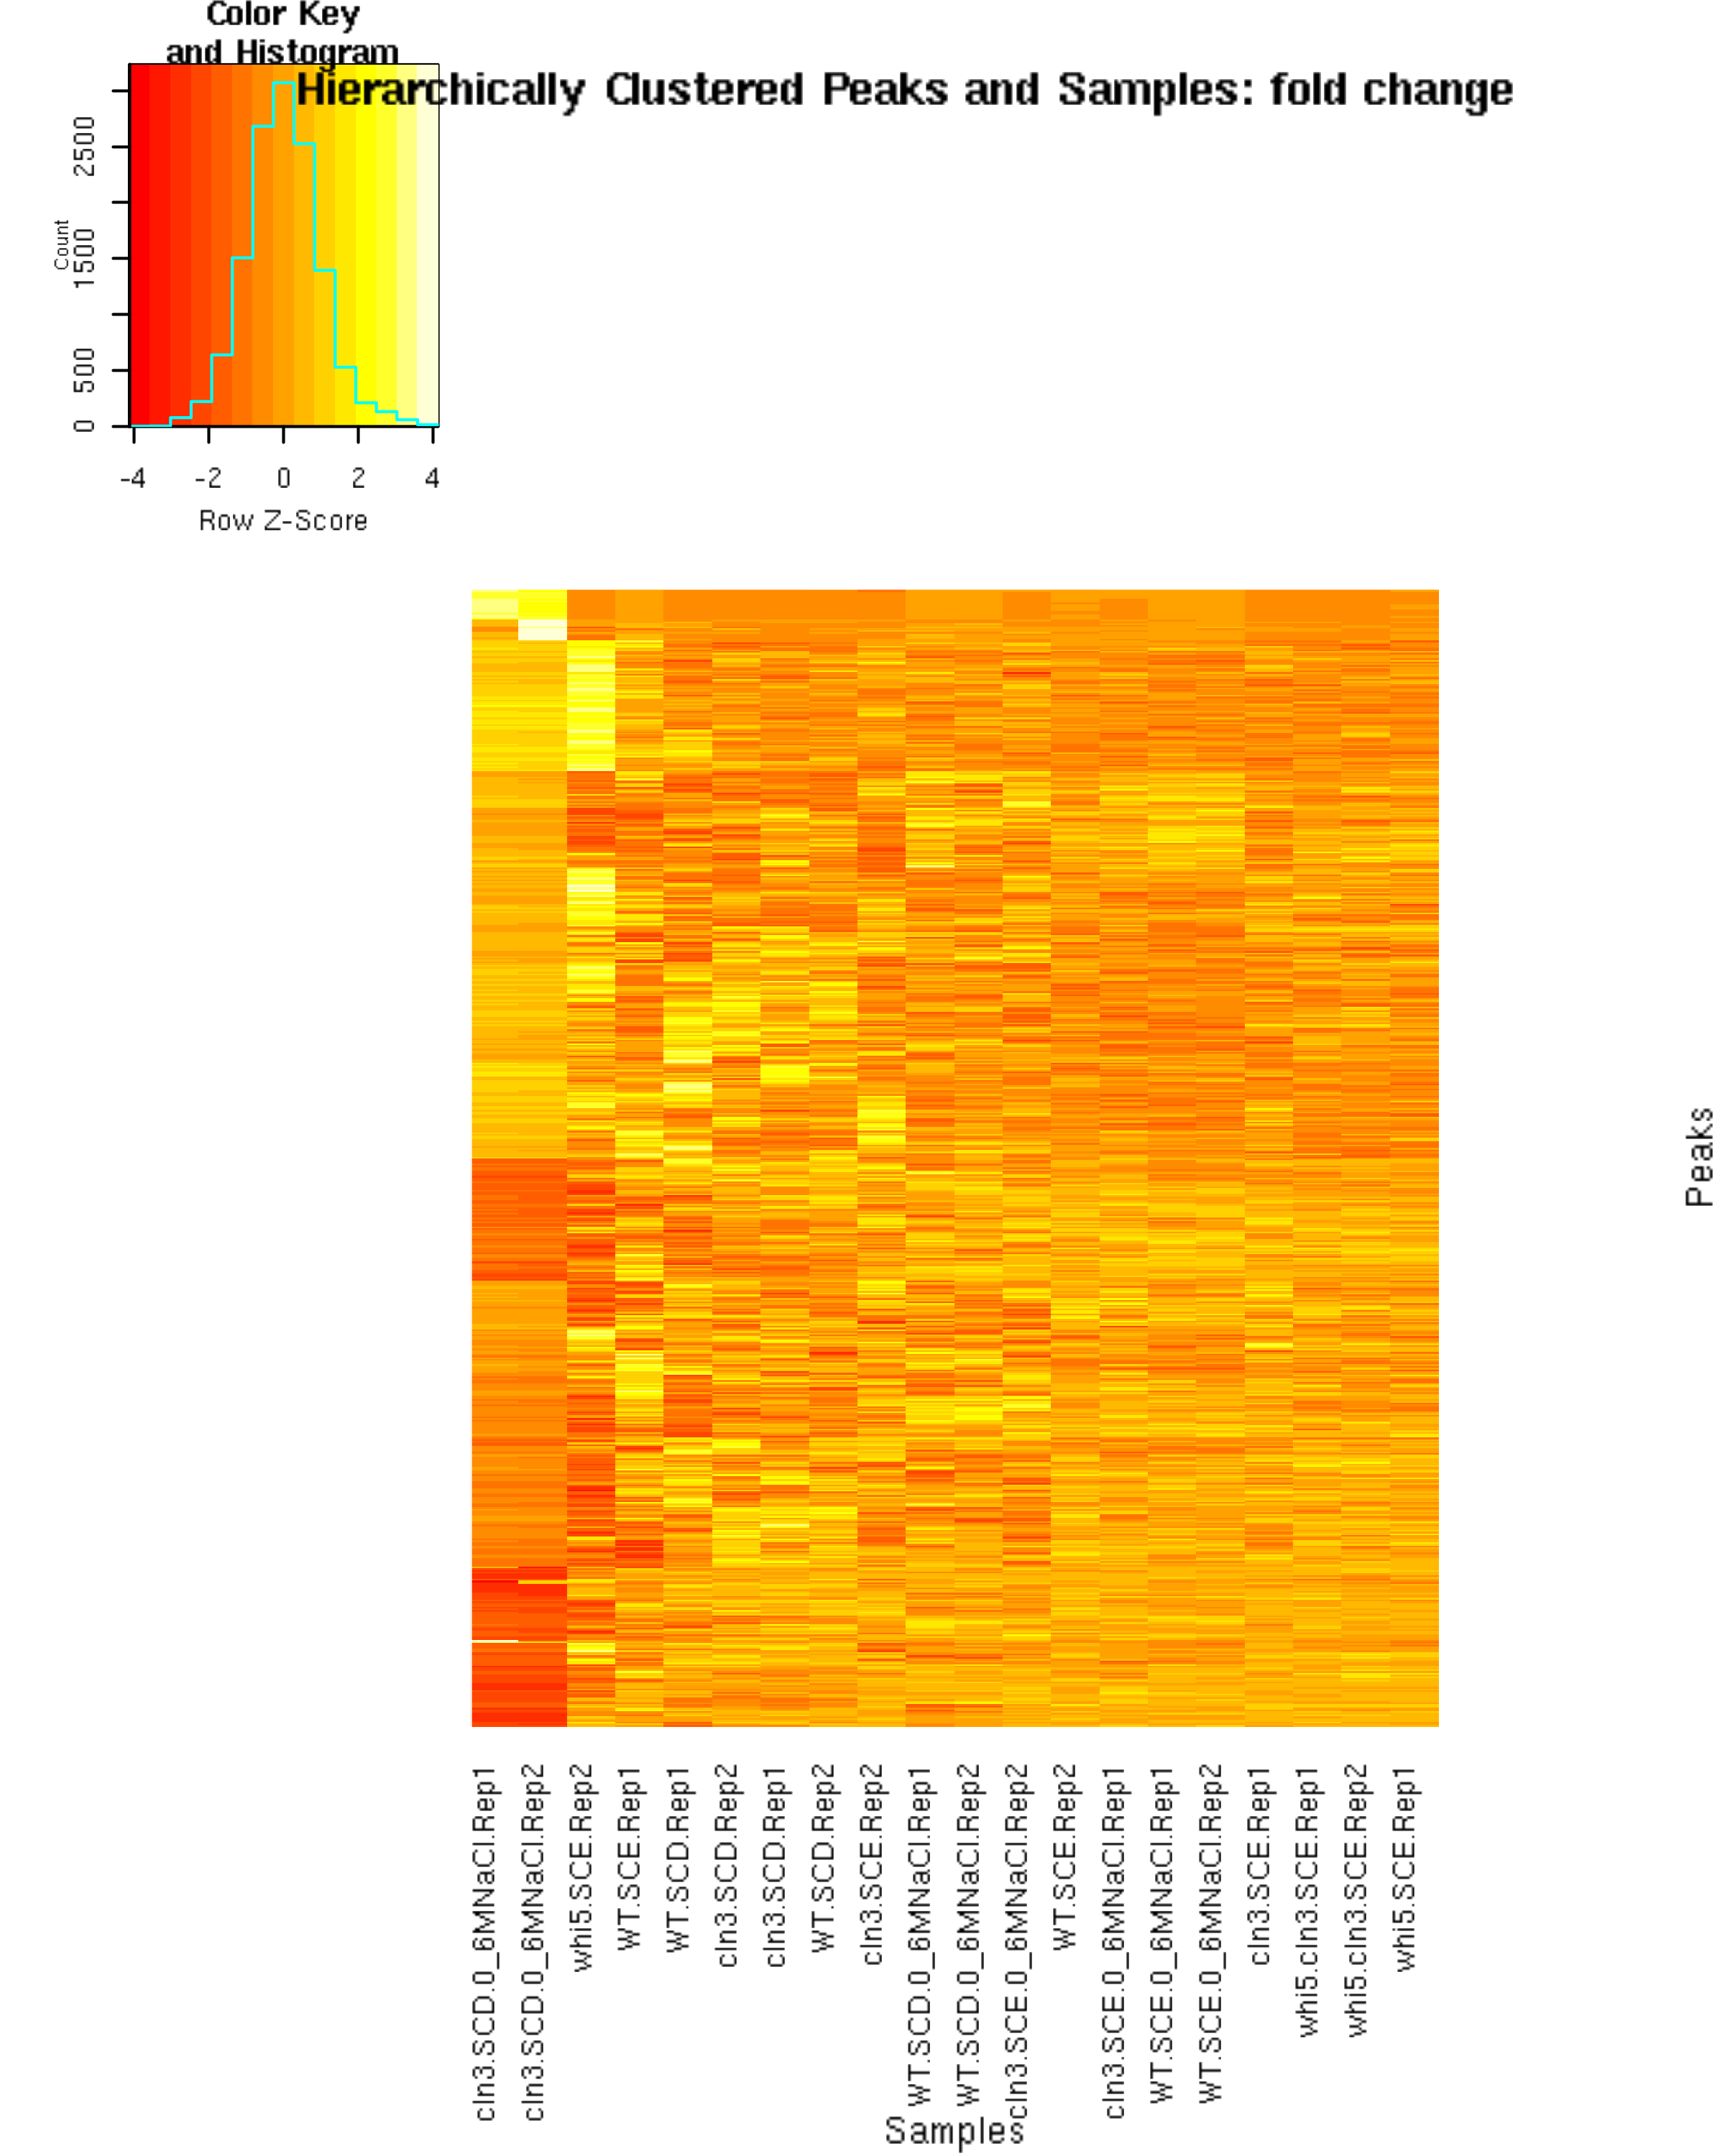

In [21]:
${SRC_DIR}/process_peaks.sh
display < ${SIGNAL_DIR}/counts_cluster.png 
display < ${SIGNAL_DIR}/foldChange_cluster.png

## Heatmap generation ##

Note that the last step in the script above is to generate heatmaps. This step may fail if X11 is not installed. One solution is to copy the foldChange.tab file to your local computer, and then run:

**[path/to/]visualize_clusters.R foldChange.tab foldChange.png**

Note that visualize_clusters.R is obtained from the github repository of scripts: https://github.com/kundajelab/training_camp/blob/master/src/visualize_clusters.R

## PCA ##

PCA (Principal Component Analysis) is a way to identify the primary directions of variation in the data. It can also be used for very coarse-grained clustering of samples; similar samples will have similar coordinates along the principal axes.

We will perform PCA on foldChange.tab. The first step is to clean up the column labels in foldChange.tab with the following perl one-liner:

In [22]:
cd $SIGNAL_DIR
perl -i".bak" -pe '$_ = $.==1 ? do {$_ =~ s/\/[^\s]+\///g; $_ =~ s/\"//g; $_ =~ s/\-/\./g; $_ =~ s/PooledReps_Sample/samp/g; $_} : $_' $MASTER_DATA/foldChange.tab
sed -i 's/\_R1.trimmed.nodup\_FE//g' $MASTER_DATA/foldChange.tab

We will now do PCA. We treat each sample as a single point in a very high dimensional space (where the dimensionality is equal to the number of genes the vary), and then we will perform dimensionality reduction in this space. We can color-code the PCA plots by "Strain", "Media", "Salt", or "Rep" to determine which parameter separates the samples most effectively. 

In [2]:
TODO:

explain pca code 
use qplot code 

add in batch correction section 
run model with confounders vs base model & subtract out the difference 
hide file i/o code 


TODO:: command not found
The program 'explain' is currently not installed. You can install it by typing:
sudo apt install explain
No command 'use' found, did you mean:
 Command 'muse' from package 'muse' (universe)
 Command 'fuse' from package 'fuse-emulator-gtk' (universe)
 Command 'fuse' from package 'fuse-emulator-sdl' (universe)
 Command 'nse' from package 'ns2' (universe)
use: command not found


: 127

In [29]:
cd $SIGNAL_DIR
#color-code by Strain 
$SRC_DIR/doPCA.R $MASTER_DATA/foldChange.tab $MASTER_DATA/batches.txt  Strain

Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 


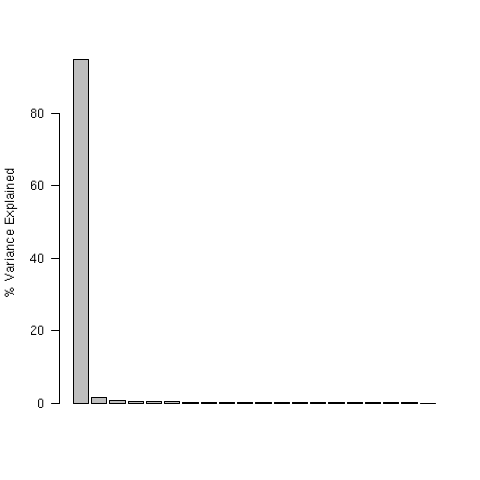

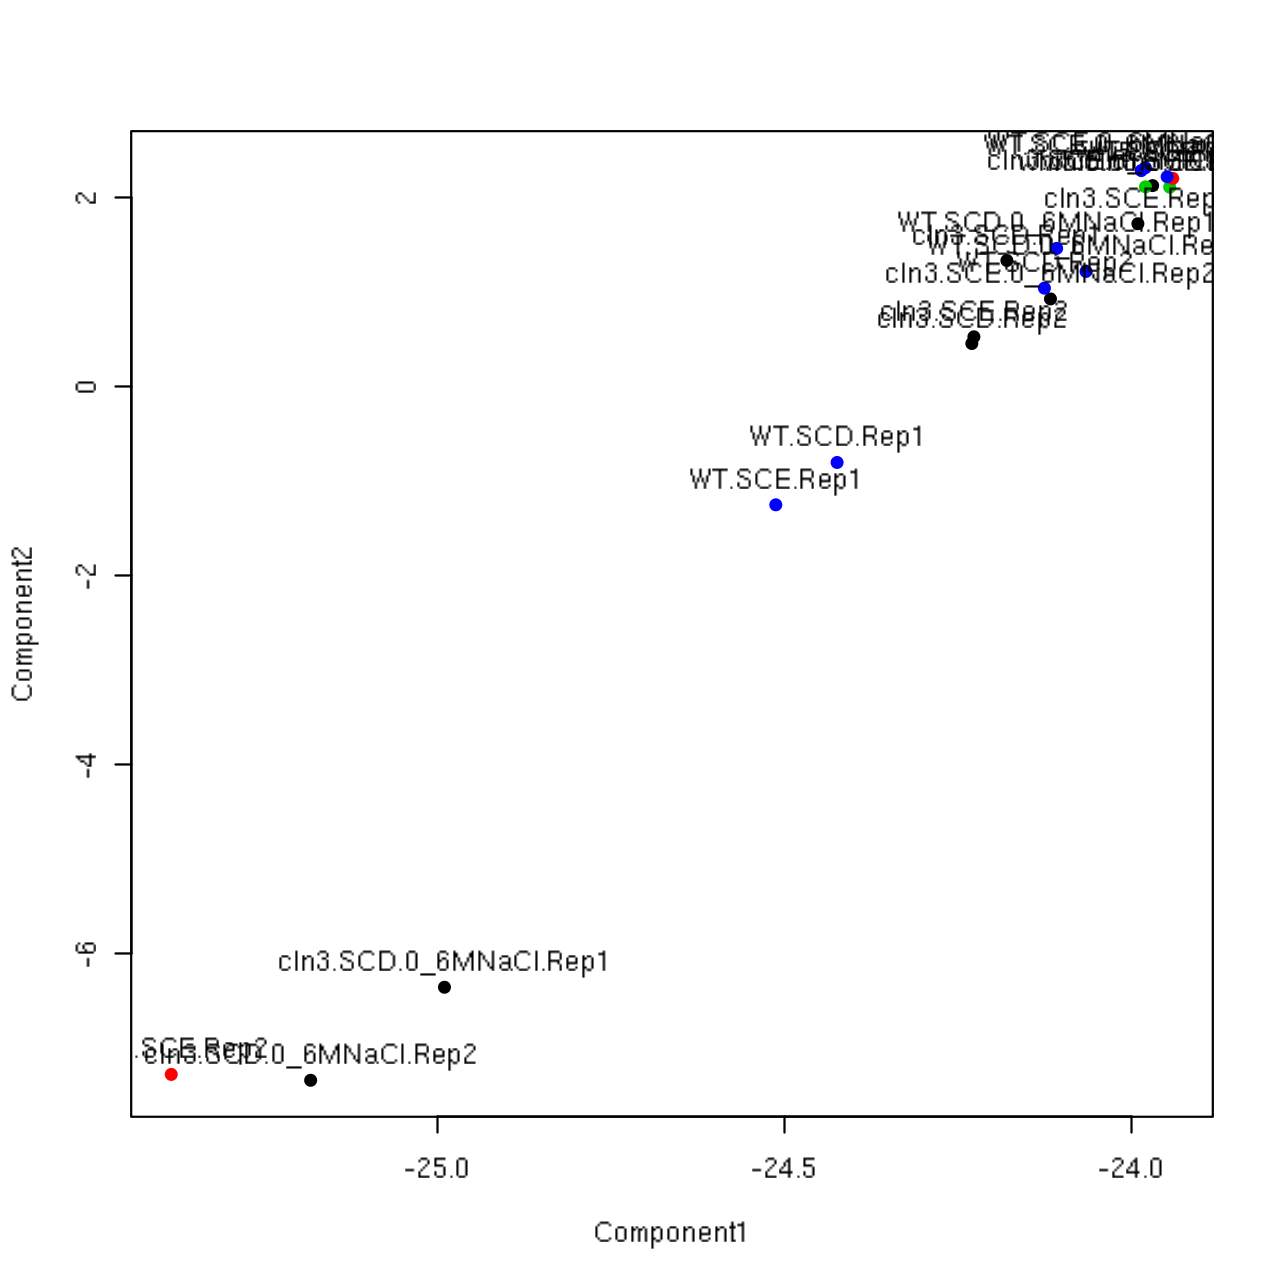

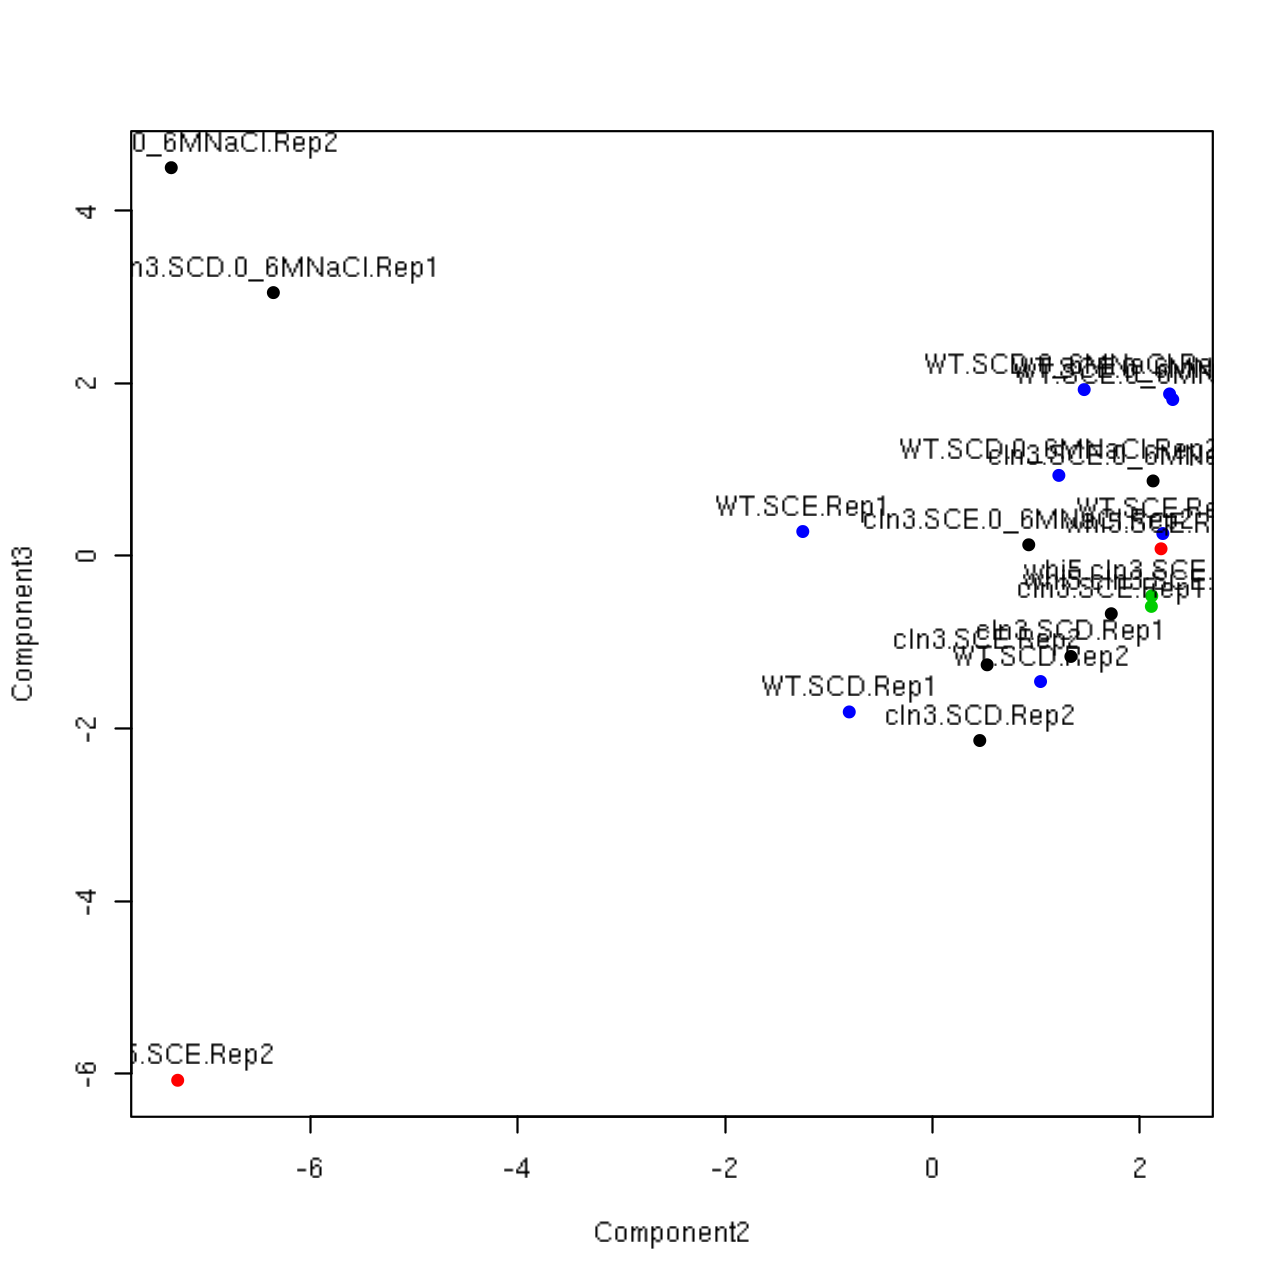

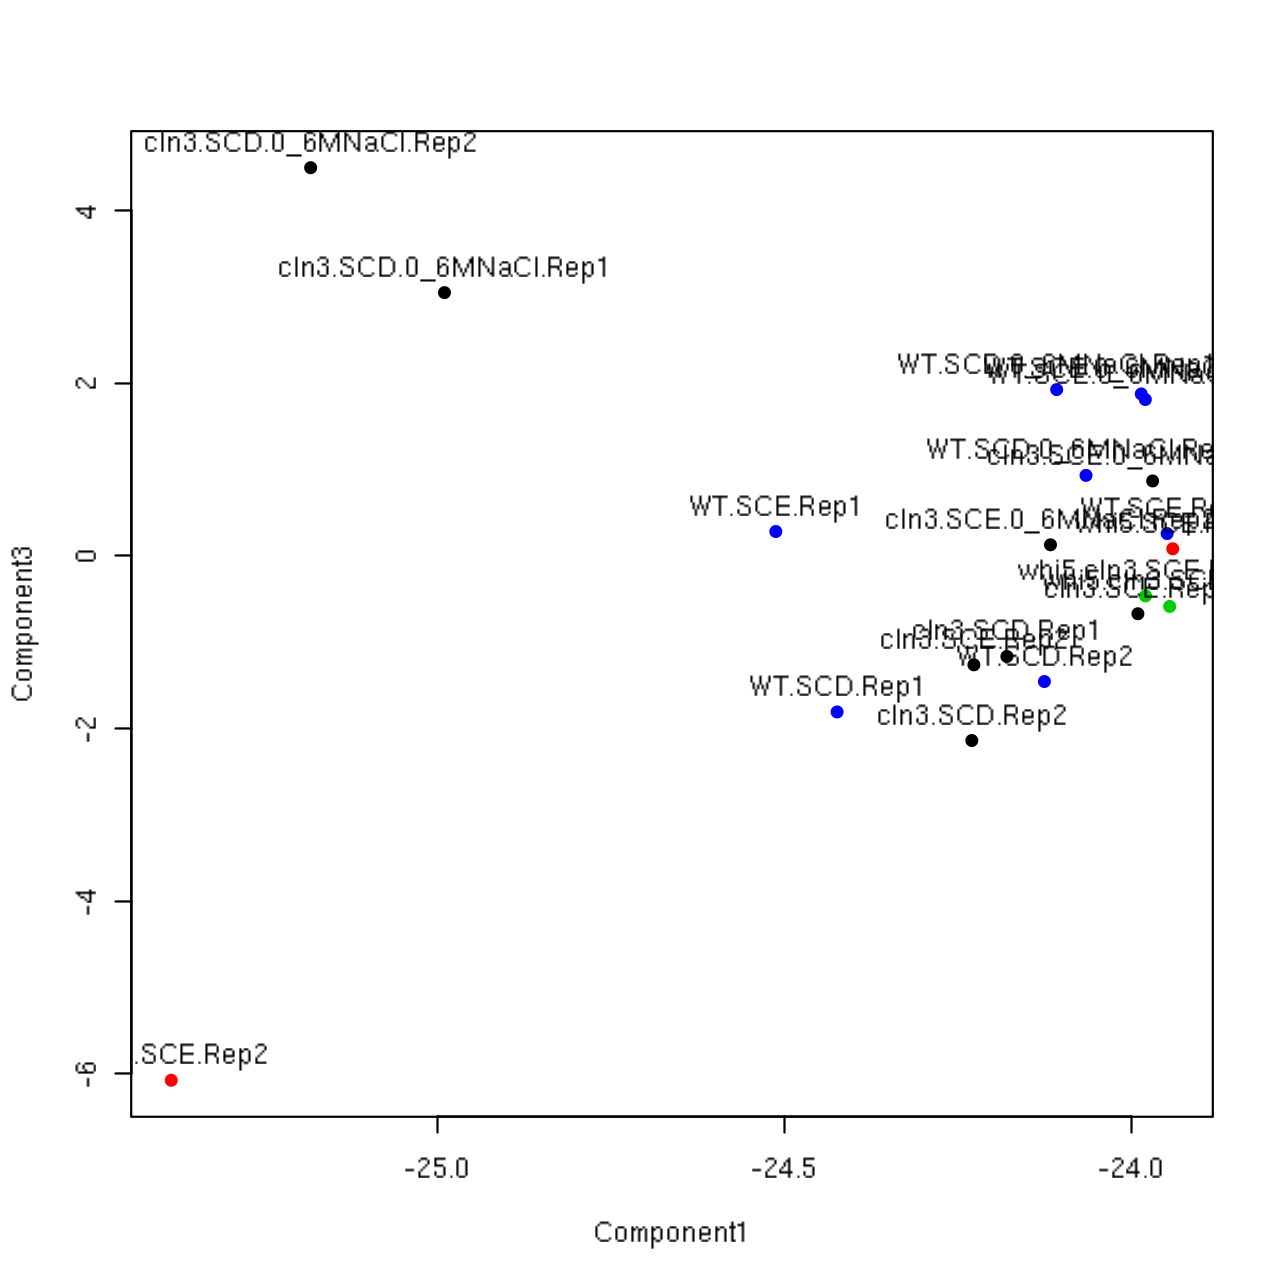

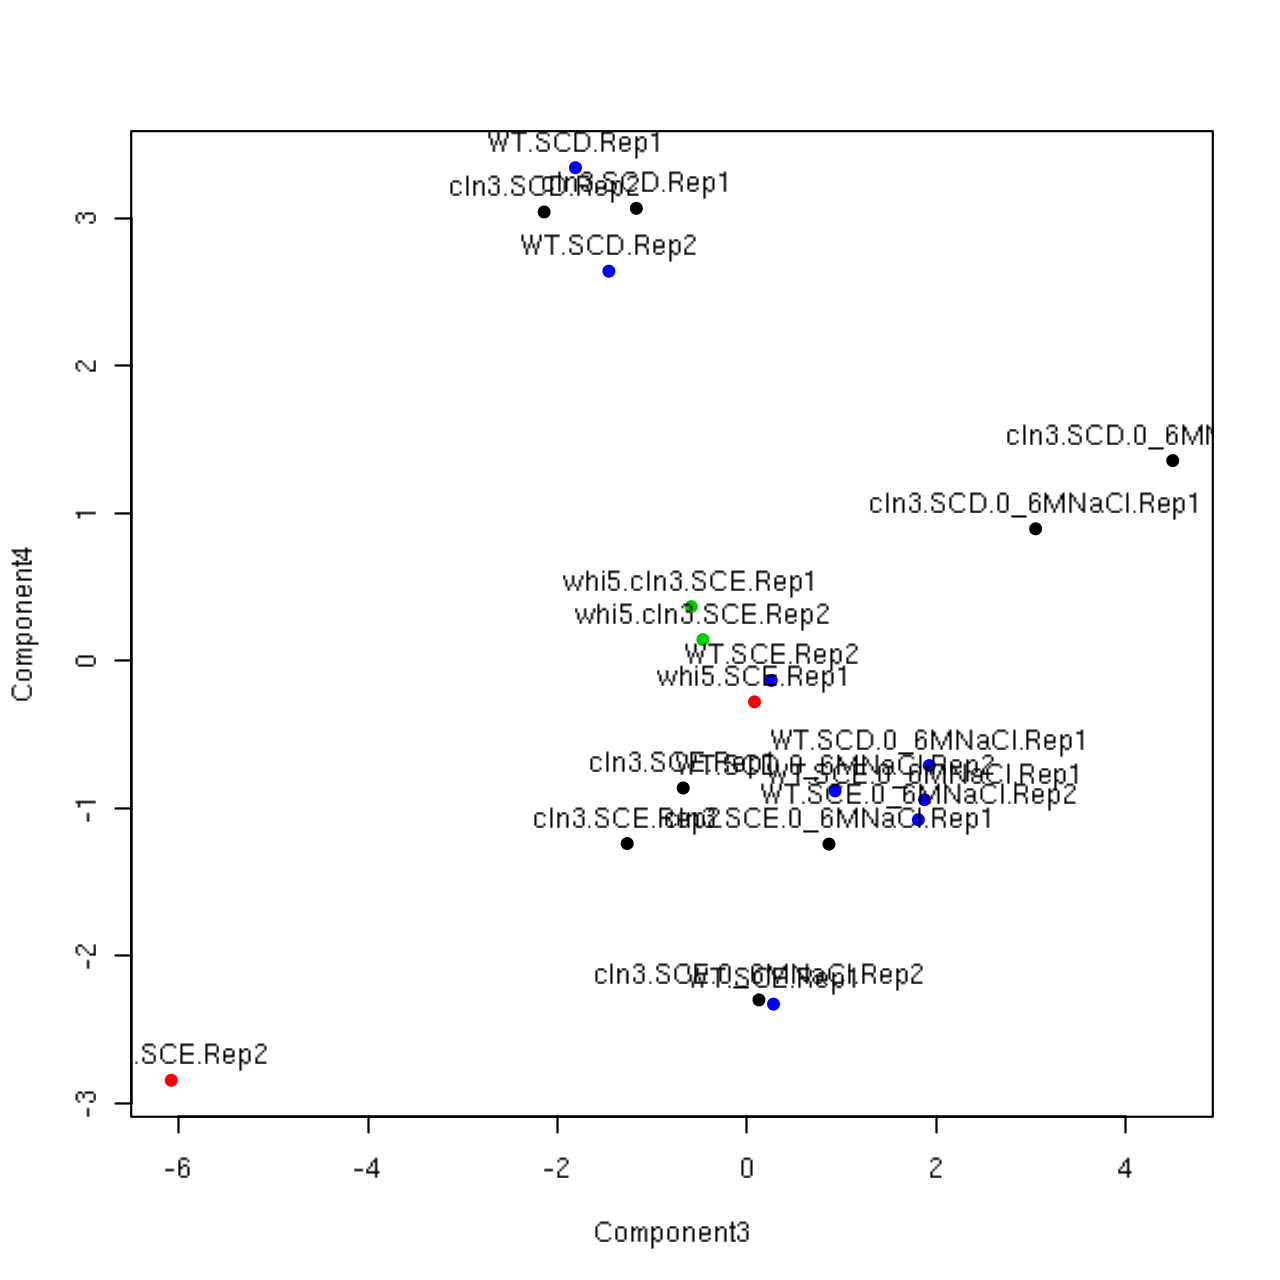

In [27]:
#display the resulting PCA images
display < PCA_scree_plot.png
display < PC_1_vs_2.png 
display < PC_2_vs_3.png 
display < PC_1_vs_3.png
display < PC_3_vs_4.png 

Strain does not appear to be the main separator for the samples. What about media? 

Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 


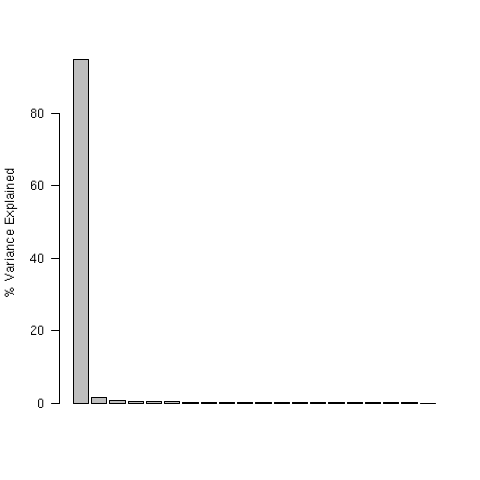

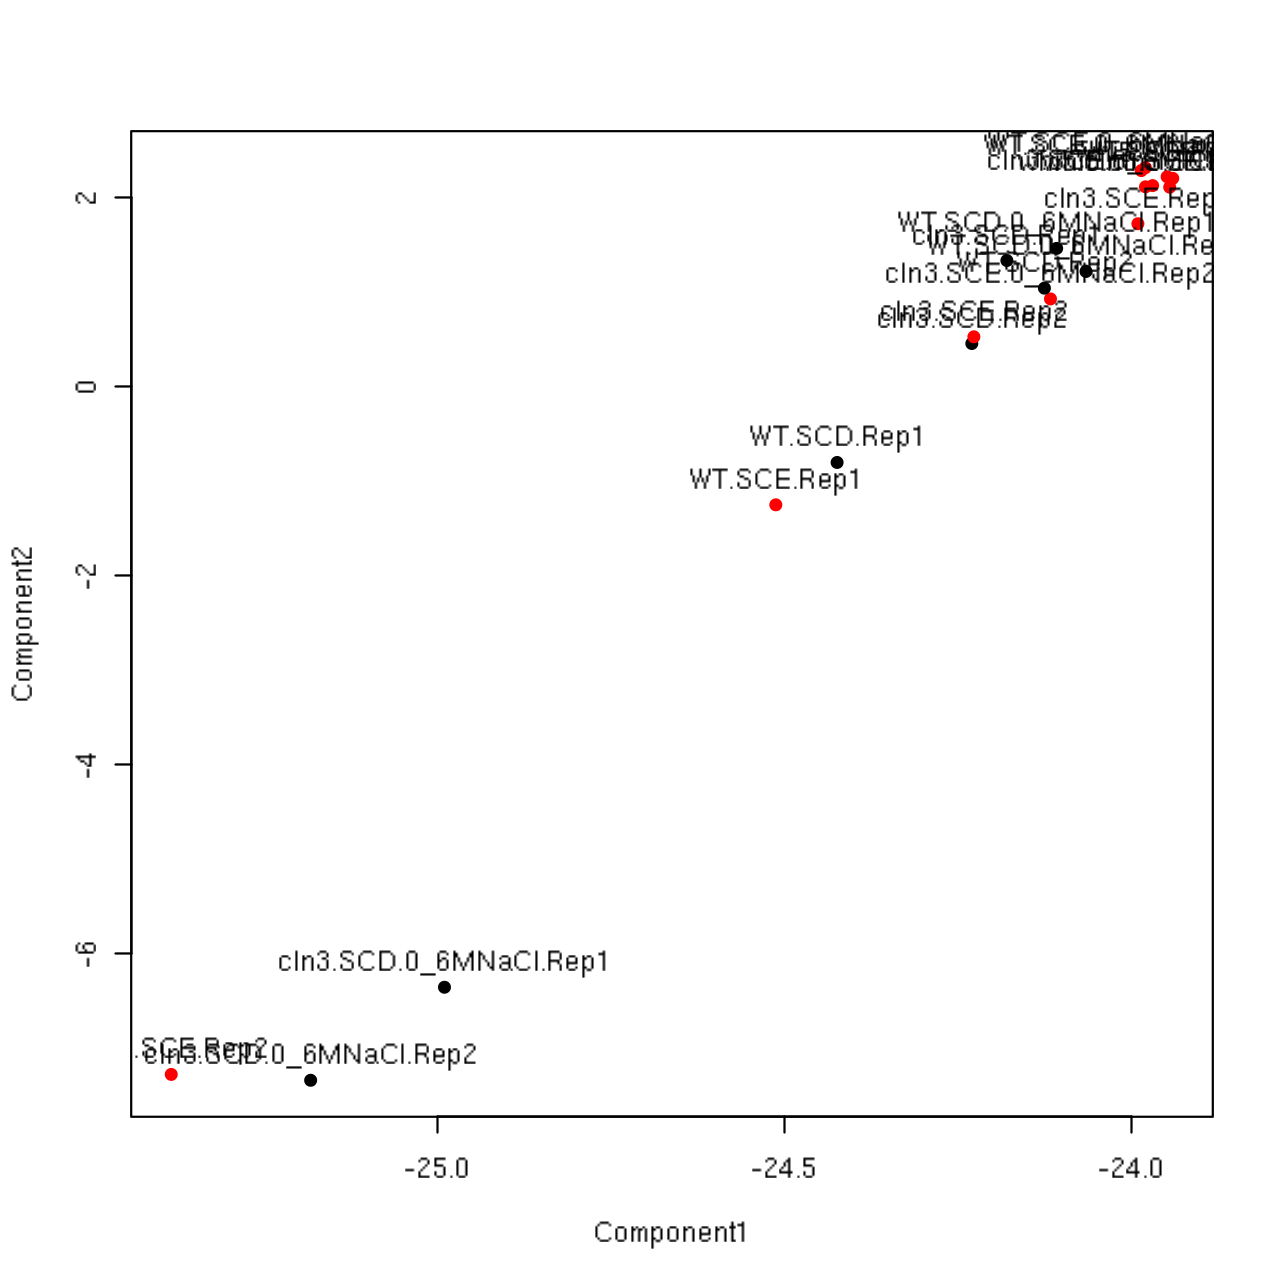

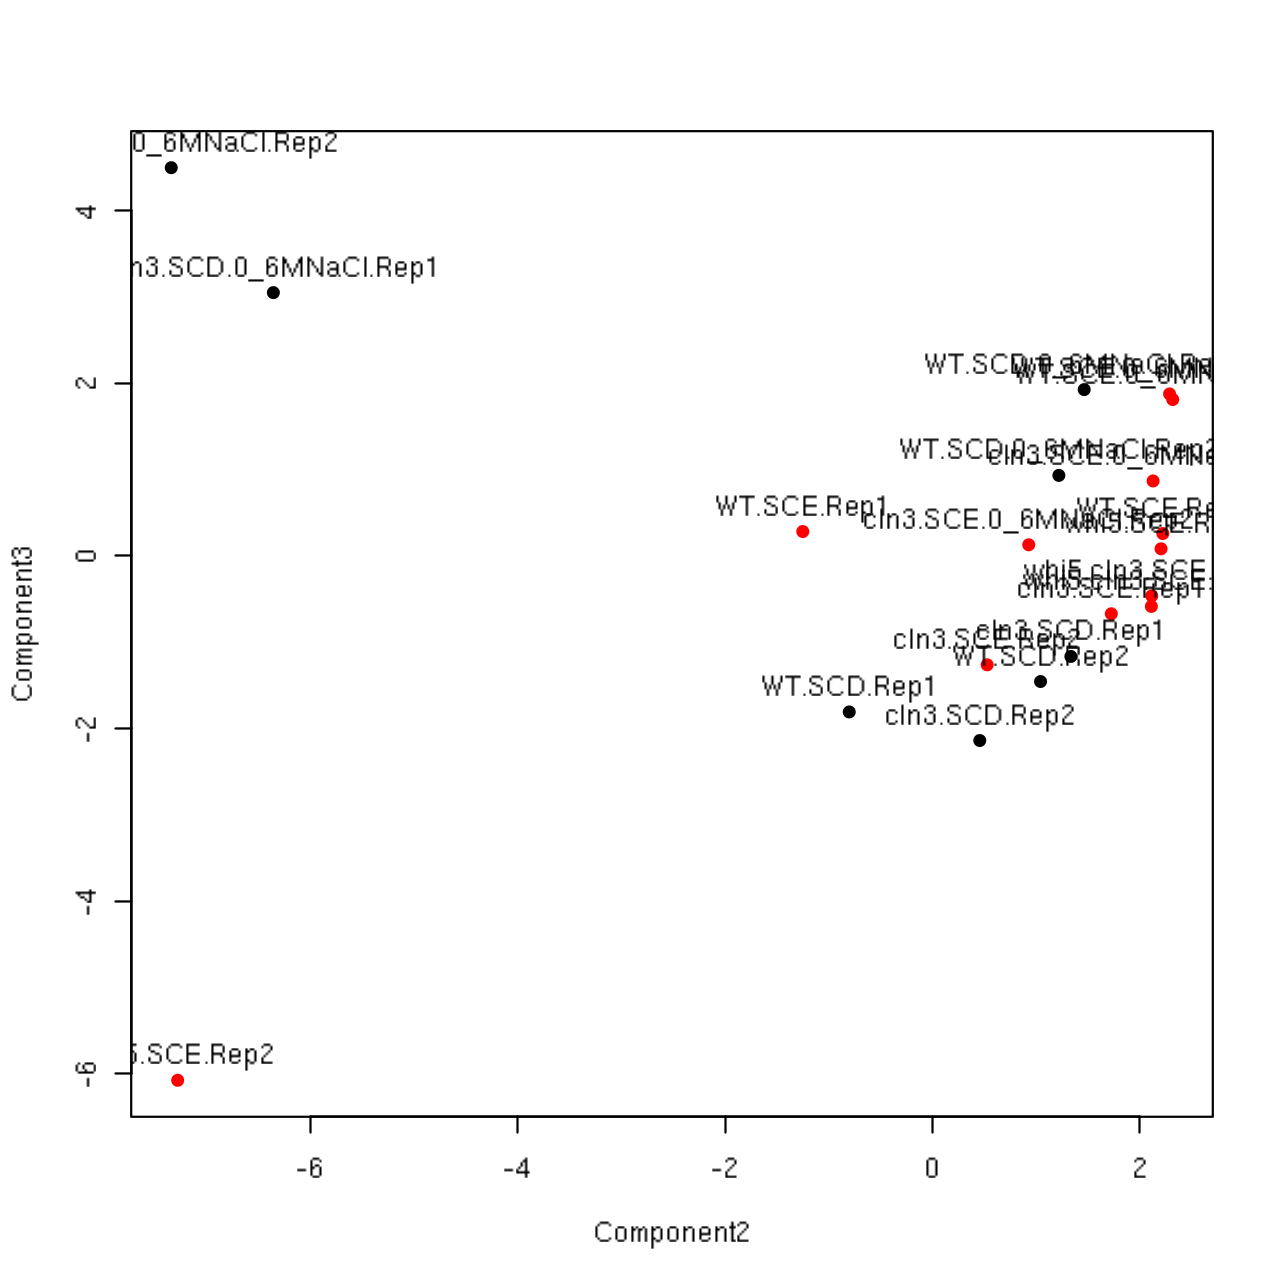

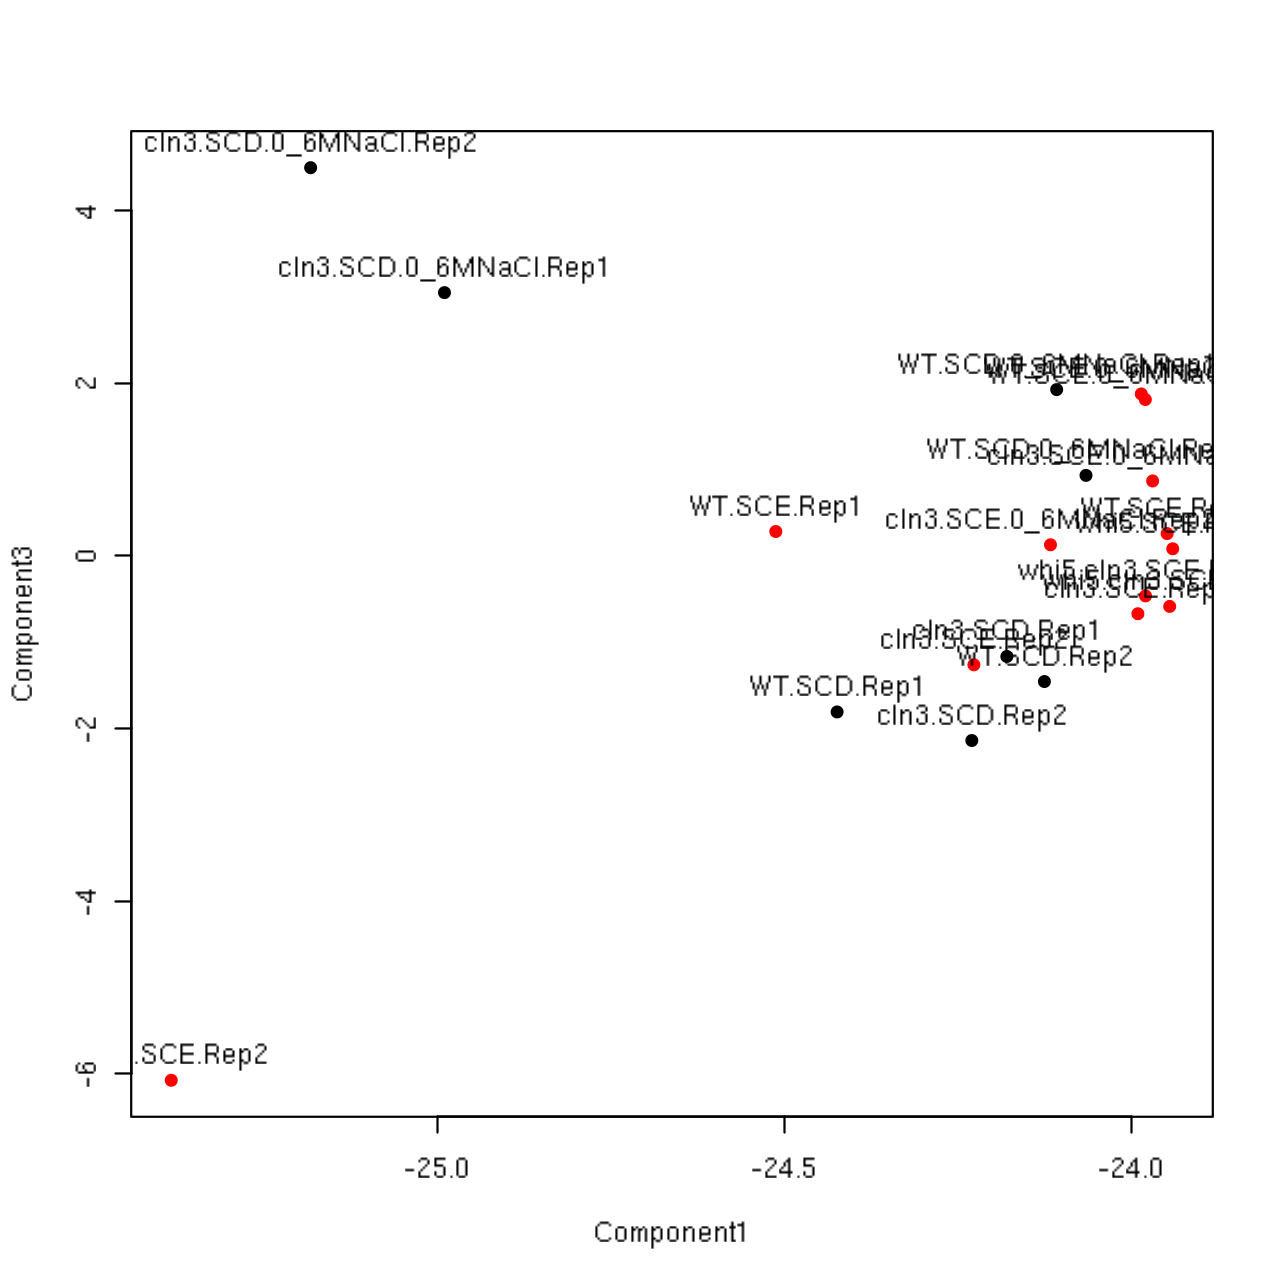

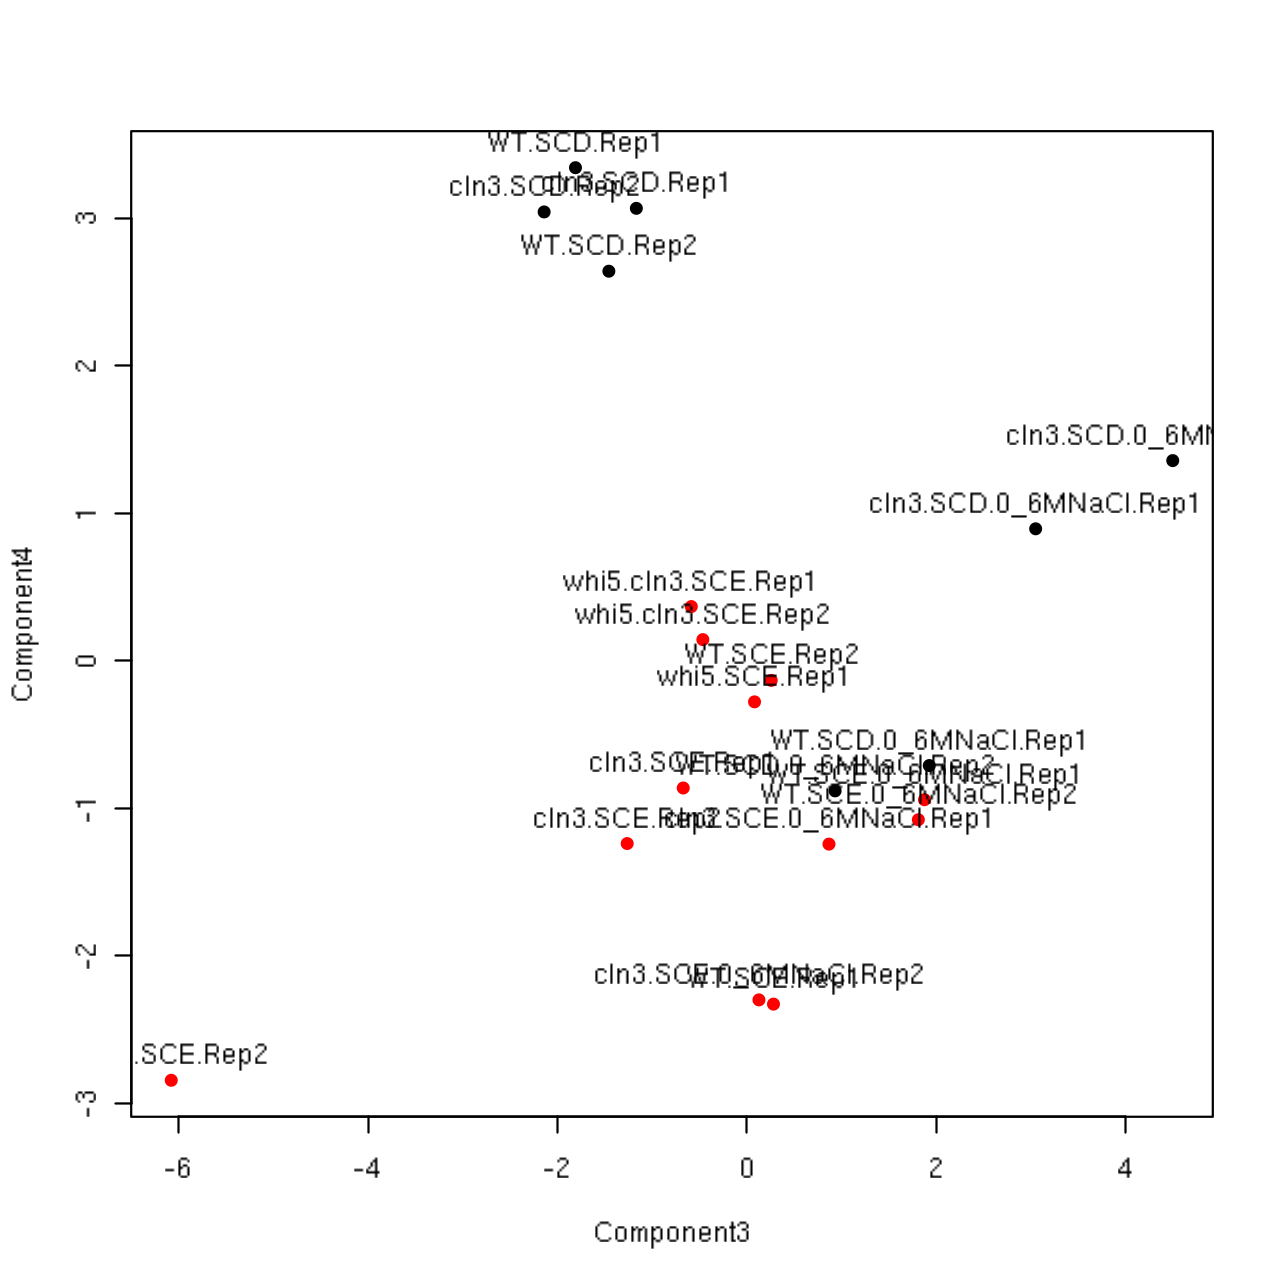

In [30]:
$SRC_DIR/doPCA.R $MASTER_DATA/foldChange.tab $MASTER_DATA/batches.txt Media
#display the resulting PCA images
display < PCA_scree_plot.png
display < PC_1_vs_2.png 
display < PC_2_vs_3.png 
display < PC_1_vs_3.png
display < PC_3_vs_4.png 

Exercise: Repeat the above analysis for "Salt" and "Rep" variables. What PC is explained by Media? What PC is explained by Salt? 

We see that principal component 1 is pulling out the three samples that had very low read count : 

* Cln3-SCD-0_6MNaCl-Rep1
* Cln3-SCD-0_6MNaCl-Rep2

Interestingly, a sample with a relatively high number of reads is being separated as well: 
* Whi5-SCE-Rep2

Let's remove the 2 samples with low reads and re-run the PCA analysis. These 3 samples have been removed from the foldChange file to generate the file **$MASTER_DATA/foldChange.filtered.tab**

Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 


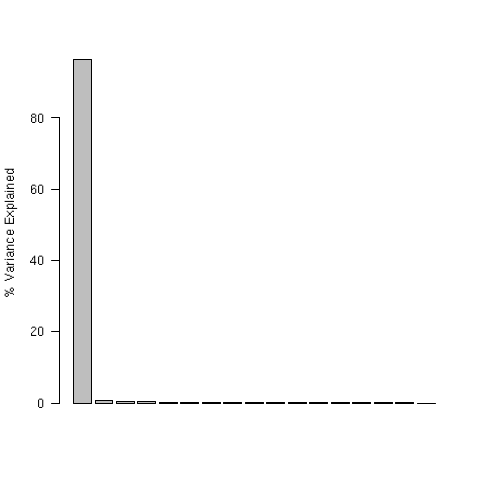

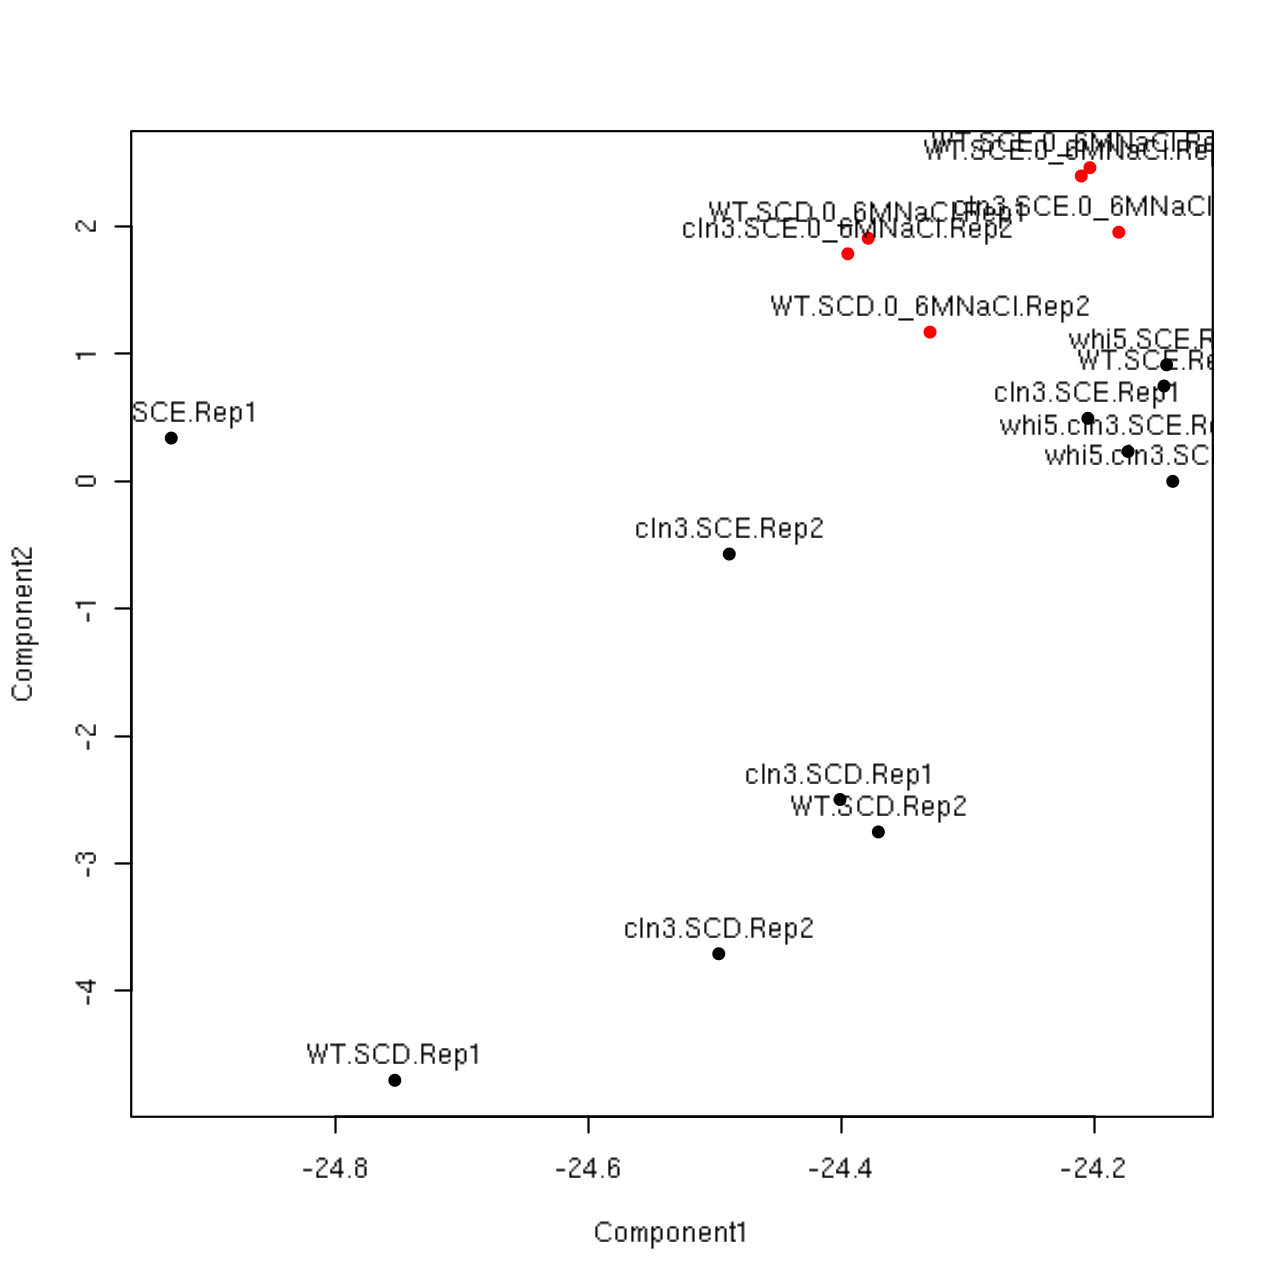

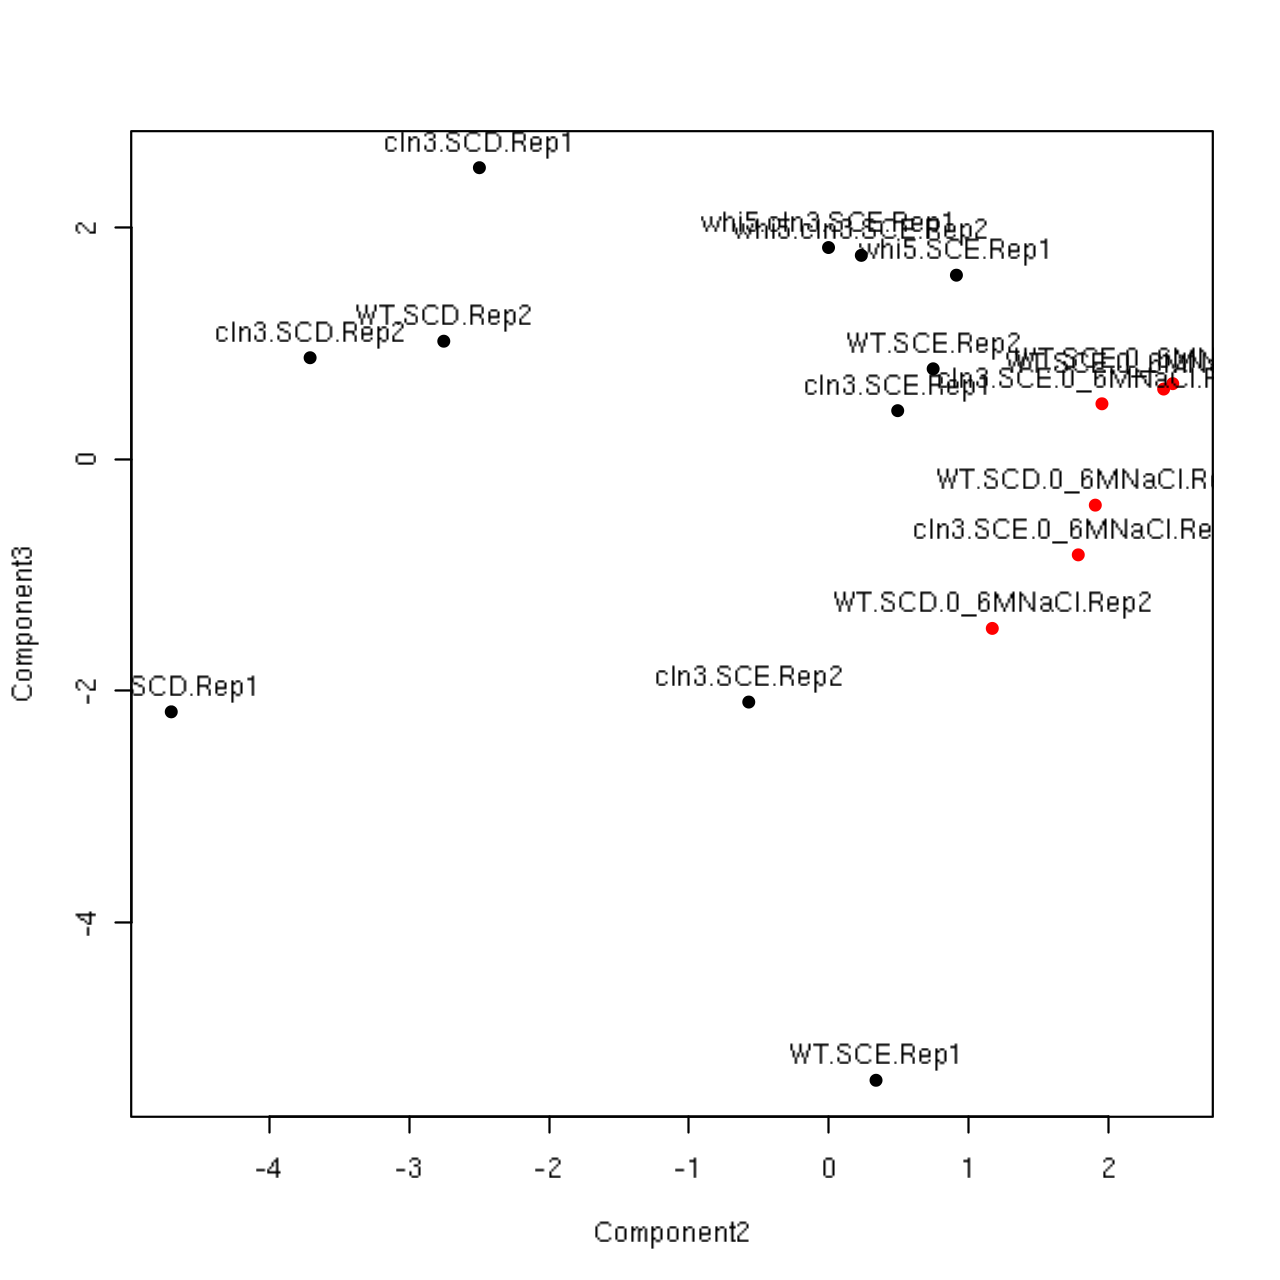

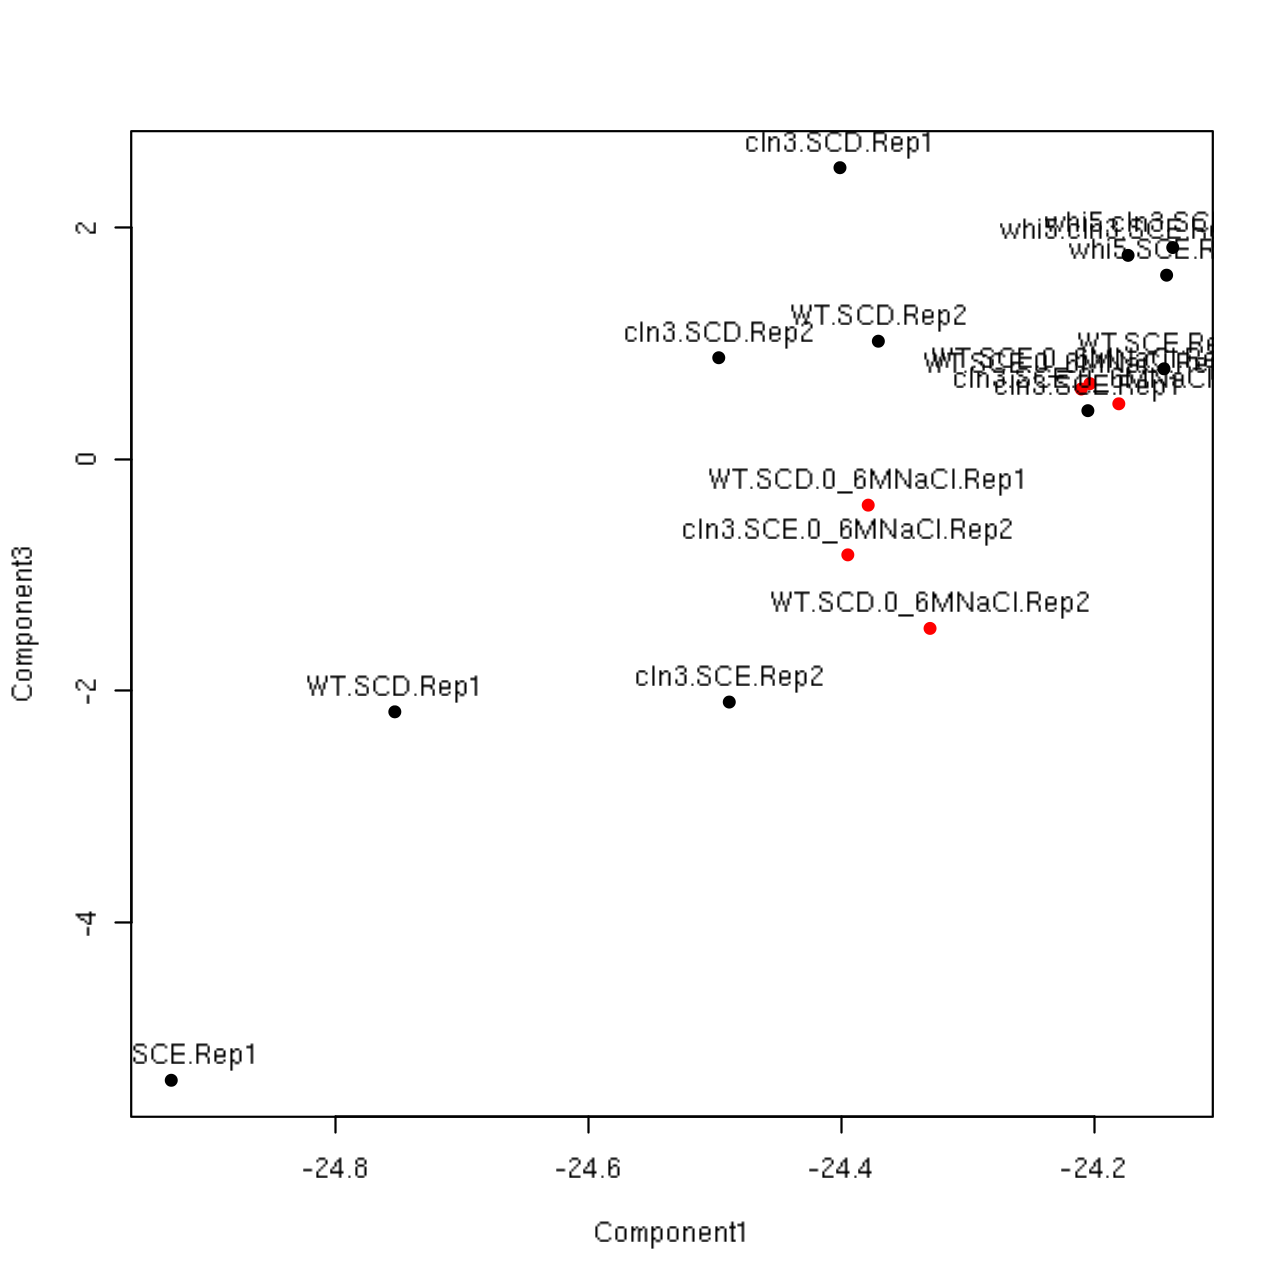

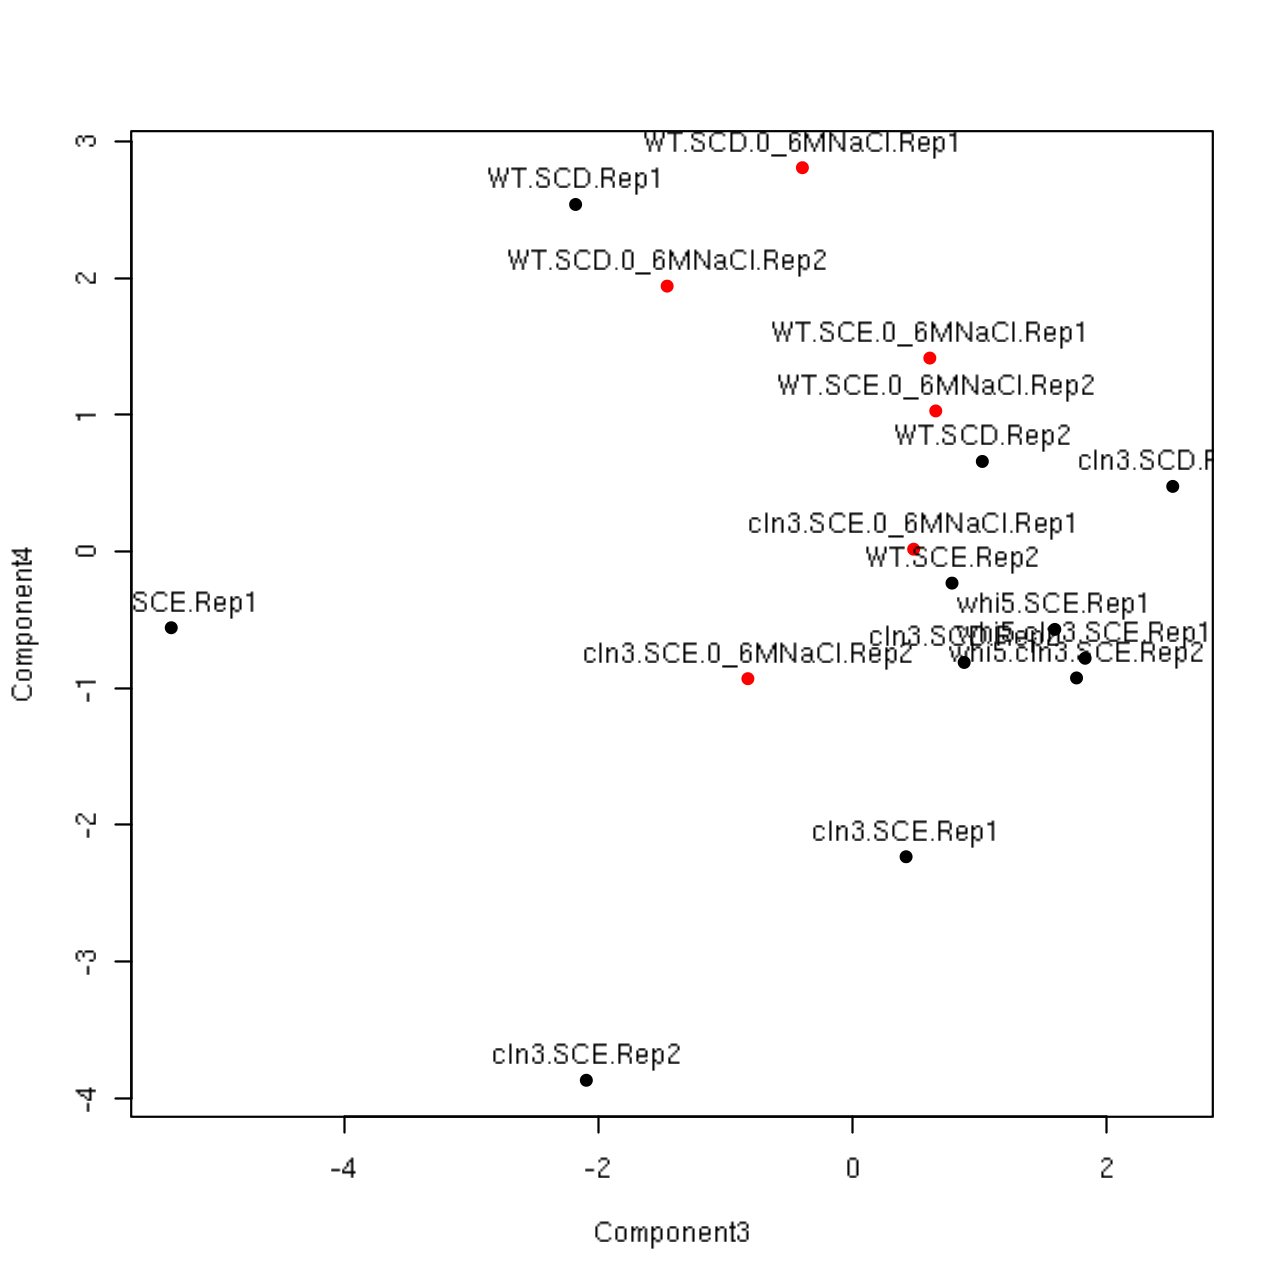

In [33]:
$SRC_DIR/doPCA.R $MASTER_DATA/foldChange.filtered.tab $MASTER_DATA/batches.filtered.txt  Salt
#display the resulting PCA images
display < PCA_scree_plot.png
display < PC_1_vs_2.png 
display < PC_2_vs_3.png 
display < PC_1_vs_3.png
display < PC_3_vs_4.png 

In [34]:
head -n20  pc1_rotation.txt

1 -0.0396636322526643
2 -0.0392642951489663
3 -0.0383825908060392
4 -0.0387217369610497
5 -0.0392450616915188
6 -0.0394462764855993
7 -0.0392792221725189
8 -0.0392947613181278
9 -0.038922126639388
10 -0.0396837312353072
11 -0.0394343167667778
12 -0.0391473683822406
13 -0.0389171142008732
14 -0.038953719666775
15 -0.038688953662371
16 -0.0394172590519695
17 -0.0395542540408932
18 -0.0391992770650169
19 -0.0394150256980142
20 -0.0393188989768102


In [35]:
head -n20 pc2_rotation.txt

1 0.026741756916798
2 -0.0390599942064288
3 -0.0640610122337685
4 -0.00173960562159764
5 -0.0314987056395985
6 -0.00662698620753562
7 0.00708586181447335
8 -0.0475692291283936
9 -0.0444886170112842
10 -0.00764802706259375
11 -0.00235817986292878
12 -0.0478379135373259
13 -0.0353118653162209
14 -0.0424467914752256
15 -0.0390695470131349
16 -0.0240546291007056
17 -0.0483786037092966
18 -0.0167322627842767
19 0.0305171212323898
20 0.0175190077102892


This script will produce PCA_sdev.png, which shows the standard deviation explained by each of the principle components. Since there are only 32 datapoints, the effective dimensionality of our data is 32, even though there are thousands of genes; this is why there are only 32 PCs.

It also produces PC_[x]_vs_[y].png for components 1..3. How do you interpret the different principle components?

Finally, it produces the files pc[x]_rotation.txt for components 1..3, which show the contribution of each peak to the direction of the principle component; this file can be used to get a sense of which peaks are critical in defining the principle components, and in which direction (positive or negative). One interesting analysis we can do with these files is to sort the peaks by their contribution to the principle component in ascending or descending order, map the peaks to their nearest genes, and then used the ranked list with software such as GOrilla which accept a ranked list of genes and output which GO terms are overrepresented towards the top: (http://cbl-gorilla.cs.technion.ac.il/)

First, identify genes that are nearest to the peaks:

In [36]:
cd $PEAKS_DIR
bedtools closest -D a -a $MASTER_DATA/all_merged.peaks.bed.gz -b $SRC_DIR/yeast_tss_coords.bed > peaks2genes.bed

The following commands will sort the genes by their contribution to each principle component and then map them to their nearest gene:

In [37]:
cd $SIGNAL_DIR
for pcFile in `ls pc*_rotation.txt`; do
    theBase=`basename ${pcFile}`
    cat $pcFile | sort -k 2r > "ascending_"$theBase
    cat $pcFile | sort -k 2rg > "descending_"$theBase
done
$SRC_DIR/mapToNearestPeak.py --sigPeakInputFiles ascending*.txt descending*.txt --peaks2genesFile $PEAKS_DIR/peaks2genes.bed

You can examine the output:

In [38]:
ls nearestGene* 

nearestGenes_ascending_pc1_rotation.txt
nearestGenes_ascending_pc2_rotation.txt
nearestGenes_ascending_pc3_rotation.txt
nearestGenes_descending_pc1_rotation.txt
nearestGenes_descending_pc2_rotation.txt
nearestGenes_descending_pc3_rotation.txt


Use the **head** command to print a specified number of lines from a file.
Use the **cat** command to print the full contents of the file.

In [39]:
#example: print first 20 lines in nearestGenes_ascending_pc1_rotation.txt
head -n20 nearestGenes_ascending_pc1_rotation.txt

YAR042W
YKR076W
YCR006C
YLR448W
YBR230W-A
YLR438W
YFR053C
Q0050
YKR013W
YBR211C
YLR154C-G
YCR063W
YGR270W
YPR196W
YER182W
YJR128W
YKR092C
YPR184W
YDR540C
YJR150C


Exercise: copy & paste the lists of genes into GOrilla (http://cbl-gorilla.cs.technion.ac.il/) to discover over-represented GO terms.

In [40]:
#we create a symbolic link to the gene file, so that you can load it directly into GOrilla. 
ln -s $SIGNAL_DIR/nearestGenes_ascending_pc1_rotation.txt ~/training_camp/workflow_notebooks

ln: failed to create symbolic link ‘/home/user1/training_camp/workflow_notebooks/nearestGenes_ascending_pc1_rotation.txt’: File exists


In [41]:
ls ~/training_camp/workflow_notebooks

0.0 Introduction to Jupyter notebooks.ipynb
1.0 Big Ideas.ipynb
1.1 Unix Basics.ipynb
1.2 Shell scripts and job submission.ipynb
1.3 Getting ready to run code on the cluster.ipynb
2.0 The metadata file and analysis overview.ipynb
2.1_Sequencing_Data_Analysis.ipynb
2.2 Creating count coverage and fold change tracks.ipynb
3.1 Clustering analysis and PCA.ipynb
3.2 Calling differentially expressed peaks.ipynb
3.3 GO Term Enrichment.ipynb
3.4 Finding TF motifs.ipynb
3.5 Install Missing R packages.ipynb
Adhoc_bash_notebook.ipynb
nearestGenes_ascending_pc1_rotation.txt
part1.png
part2.png
part3.png
part4.png
part5.png
part6.png
pipeline_1.png
pipeline_2.png
qc_analysis
tc2017_pipeline.png
